In [2]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import scipy.io
from cv2 import  copyMakeBorder, BORDER_CONSTANT

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, Dropout

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing joints locations and images - correcting size of the images

In [8]:
coords_file_name = "/content/drive/My Drive/Deep/HW02/lsp_dataset/joints.mat"
joints = scipy.io.loadmat(coords_file_name)
joints = joints['joints'][:2,:]

image_list = []

for i in range(1,2001):
  if np.mod(i,50)==0:
    print(i)
  if i<10:
    img_name = "im000{0}.jpg".format(i)
  elif i<100:
    img_name = "im00{0}.jpg".format(i)
  elif i<1000:
    img_name = "im0{0}.jpg".format(i)
  else:
    img_name = "im{0}.jpg".format(i)

  img = plt.imread("/content/drive/My Drive/Deep/HW02/lsp_dataset/images/{0}".format(img_name))

  if img.shape[0] < 220:
    height = 220 - img.shape[0]
  else:
    height = 0

  if img.shape[1] < 220:
    width = 220 - img.shape[1]
  else:
    width = 0
  
  if np.mod(width,2) == 0:
    extra_width = 0
  else:
    extra_width = 1

  if np.mod(height,2) == 0:
    extra_height = 0
  else:
    extra_height = 1

  joints[0,:,i-1] = (joints[0,:,i-1] + width/2)/220
  joints[1,:,i-1] = (joints[1,:,i-1] + height/2)/220

  img = copyMakeBorder(img,int(height/2)+extra_height,int(height/2),int(width/2)+extra_width,int(width/2),BORDER_CONSTANT,value=[0,0,0])

  image_list.append(img/255)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000


### Separating train, test, and validation

In [17]:
X_train = np.array(image_list[0:1400])
Y_train = np.array(joints[:,:,0:1400])

X_train = np.reshape(X_train,(1400,220,220,3))
Y_train = np.transpose(np.reshape(Y_train,(28,1400)))

X_validation = image_list[1400:1700]
Y_validation = joints[:,:,1400:1700]

X_validation = np.reshape(X_validation,(300,220,220,3))
Y_validation = np.transpose(np.reshape(Y_validation,(28,300)))

X_test = image_list[1700:]
Y_test = joints[:,:,1700:]

X_test = np.reshape(X_validation,(300,220,220,3))
Y_test = np.transpose(np.reshape(Y_test,(28,300)))

### Running The DNN

In [18]:
batch_size = 128
epochs_number = 120
learning_rate = 5e-4
momentum = 0.9


model = tf.keras.models.Sequential()

model.add(Conv2D(48, (11, 11), activation='relu', strides=4, kernel_initializer='he_uniform', padding='same',  input_shape=(220, 220, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (5, 5), activation='relu', strides=2, kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(192, (3, 3), activation='relu', strides=1, kernel_initializer='he_uniform', padding='same'))

model.add(Conv2D(192, (3, 3), activation='relu', strides=1, kernel_initializer='he_uniform', padding='same'))

model.add(Conv2D(192, (3, 3), activation='relu', strides=1, kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(28, activation='linear'))

def soft_acc(y_true, y_pred):
    return tf.keras.backend.mean(tf.keras.backend.equal(tf.keras.backend.round(y_true), tf.keras.backend.round(y_pred)))

def l2_loss(y_true, y_pred):
  x_diff =  y_true[0:14] - y_pred[0:14]
  y_diff =  y_true[14:28] - y_pred[14:28]
  diff = tf.math.pow(x_diff,2) + tf.math.pow(y_diff,2)
  return tf.keras.backend.sum(diff)

def my_loss():
  def loss(y_true, y_pred):
    return l2_loss(y_true, y_pred)
  return loss
  
l2_loss_model = my_loss()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=l2_loss_model , optimizer=optimizer, metrics=[soft_acc])
model.fit(X_train, Y_train, epochs=epochs_number, batch_size=batch_size, validation_data=(X_validation, Y_validation))

test_results = model.evaluate(X_validation, Y_validation, verbose=1)
print('\n', "Test results - Loss: {0:.2f} - Accuracy: {1:.2f}%".format(test_results[0],test_results[1]))

Epoch 1/120
11/11 [==============================] - 3s 201ms/step - loss: 4344.1753 - soft_acc: 0.3740 - val_loss: 106.9948 - val_soft_acc: 0.5497
Epoch 2/120
11/11 [==============================] - 2s 166ms/step - loss: 74.5310 - soft_acc: 0.5714 - val_loss: 107.7030 - val_soft_acc: 0.5381
Epoch 3/120
11/11 [==============================] - 2s 153ms/step - loss: 36.5379 - soft_acc: 0.6113 - val_loss: 86.8575 - val_soft_acc: 0.5372
Epoch 4/120
11/11 [==============================] - 2s 149ms/step - loss: 32.5144 - soft_acc: 0.6227 - val_loss: 69.1780 - val_soft_acc: 0.5402
Epoch 5/120
11/11 [==============================] - 2s 150ms/step - loss: 23.6646 - soft_acc: 0.6327 - val_loss: 127.1838 - val_soft_acc: 0.5529
Epoch 6/120
11/11 [==============================] - 2s 167ms/step - loss: 19.6225 - soft_acc: 0.6399 - val_loss: 179.2148 - val_soft_acc: 0.5237
Epoch 7/120
11/11 [==============================] - 2s 151ms/step - loss: 18.0834 - soft_acc: 0.6410 - val_loss: 195.8023 -

InvalidArgumentError: ignored

In [40]:
print(X_train.shape)
test = model.predict(X_train)

(1400, 220, 220, 3)


In [30]:
print(test.shape)

(1400, 28)


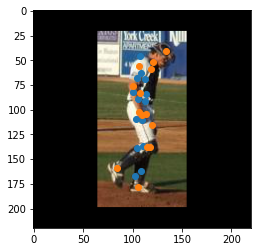

In [47]:
img_number = 3
plt.imshow(X_train[img_number])
plt.scatter(test[img_number,0:14]*220, test[img_number,14:28]*220)
plt.scatter(Y_train[img_number,0:14]*220, Y_train[img_number,14:28]*220)

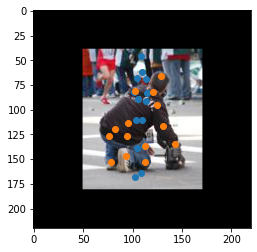

In [49]:
img_number = 10
plt.imshow(X_train[img_number])
plt.scatter(test[img_number,0:14]*220, test[img_number,14:28]*220)
plt.scatter(Y_train[img_number,0:14]*220, Y_train[img_number,14:28]*220)